# The Transverse Ising Model

We present here an example of using VQE for the TIM. We start with a 2 particle case, and then also show the 4 particle case. 

In [1]:
import numpy as np
import math as m
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
import matplotlib.pyplot as plt
#from qiskit_textbook.tools import random_state, array_to_latex # This import isn't working for me

import qiskit
print(qiskit.__qiskit_version__) # I add this so we know what versions are being used

{'qiskit-terra': '0.14.1', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.0', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.1', 'qiskit': '0.19.3'}


# To Do

-Implement Gradient descent vs. the brute force method given
-implement the entangled ansatz as a comparison

## The Two Site Ising Model


In [97]:
def ansatz(params, qc): # params should be a numpy array [theta1, phi1, theta2, phi2]
    # This is applied in expectation, and it is assumed to be applied on a |00> system
    # Sets theta = param, and the next two to 0. Last argument is the qubit number
    qc.u3(params[0], params[1], 0, 0) 
    qc.u3(params[2], params[3], 0, 1) 
    #print(qc.draw())
    return

def expZZ(index, qcO, shots_number = 1024):
    # for a given index, we measure index , index+1
    
    qc = qcO.copy()
    qc.measure(index, 0)
    qc.measure(index + 1, 1)
    #print(qc.draw())
    backend = BasicAer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=shots_number).result().get_counts() # executs the job
    
    # if 11, 00, return 1
    # if 01, 10, return -1    
    
    freq_pos = 0.0
    freq_neg = 0.0
    
    for key in counts.keys():
        if (key == '00') or (key == '11'):
            #print(key)
            #print('+')
            freq_pos = freq_pos + counts[key]
        else: #01, 10
            #print(key)
            #print('-')
            freq_neg = freq_neg + counts[key]
            
    #normalize
    freq_pos = freq_pos / shots_number
    freq_neg = freq_neg / shots_number
    
    #print(freq_pos)
    #print(freq_neg)
    #print(freq_pos + freq_neg)
    #print(counts)
    
    expZZ = (freq_pos - freq_neg)
    
    return expZZ

def expX(index, qcO, shots_number = 1024): 
    # for a given index, we measure index , index+1
    qc = qcO.copy()
    qc.h(index)
    qc.measure(index, 0) # we always measure to the first, so our results are 00 and 01
    
    backend = BasicAer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=shots_number).result().get_counts() # executes the job
    
    #print(qc.draw())
    #print(counts)
    
    freq_pos = 0.0
    freq_neg = 0.0
    
    for key in counts.keys():
        if key == '00': #the result is printed in reverse order
            #print(key)
            freq_pos = freq_pos + counts[key]
            
        else:
            freq_neg = freq_neg + counts[key]
            
    freq_pos = freq_pos / shots_number
    freq_neg = freq_neg / shots_number
    expX = freq_pos - freq_neg
    #print("expX is " + str(expX))
    #print("======")
    
    return expX

def expectation(params, h, shots_number = 1024): 
    # first, we run the quantum circuit
    # Then, using the resulting measurement, we use the numbers to calculate the expectation value
    # This function is hard-coded for a specific H. (I may change this later)
    # Since H = sigma^z, let's assume that we are in the z-basis. Then, we need only find the amplitudes of being 
    # in |0> and |1>. 
    # <H> = (Counts(0) - Counts(1)) / Normalization
    
    # Creating the circuit
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
    
    ansatz(params, qc) # Applying the ansatz preparation on a given |0>
    
    # need to run a measurement for each time
    # This is programmed specifically for 2 qubits
    expX_tot = 0.0
    i = 0
    while i < 2:
        expX_tot = expX_tot + expX(i, qc)
        #print("ExpX was " + str(expX(i,qc)))
        i += 1
    X_contribution = -h * expX_tot
    #print("The X contribution is: " + str(X_contribution))
    ZZ_contribution = -expZZ(0, qc)
    #print("The ZZ contribution is: " + str(ZZ_contribution))
    
    exp =  X_contribution + ZZ_contribution
    return exp


def grid_search():
    # Grid search is just one of many optimization functions we can use. 
    return

  
def brute_force_2theta(step_size0, step_size1, params_min, params_max, h):
    thetas_0 = np.arange(params_min[0], params_max[0], step_size0)
    thetas_1 = np.arange(params_min[1], params_max[1], step_size1)
    
    expectations = np.zeros([np.size(thetas_0), np.size(thetas_1)])
    # number of rows is the number of theta 0s, and number of columns is number of theta 1s.

    j =0
    while j<np.size(thetas_0):
        #print("Current theta0 is " + str(thetas_0[j]) + ", index " + str(j))
        i=0
        
        while i < np.size(thetas_1):
            #print("Current theta1 is: " + str(thetas_1[i]) + ",index " + str(i))
            expectations[j][i] = expectation(np.array([thetas_0[j], 0, thetas_1[i], 0]), h)
            i += 1
            #print("")
            
        
        #print(expectations[j])
        #plt.scatter(thetas_1, expectations[j])
        #plt.show()
        
        j += 1
        
    min_value = np.amin(expectations)
    min_index = np.where(expectations == min_value) # returns indices as a tuple of arrays. 
    # i.e. (array([0]), array([1])) for row 0, column 1
    index_theta0 = min_index[0][0]
    index_theta1 = min_index[1][0]
    opt_theta0 = thetas_0[index_theta0]
    opt_theta1 = thetas_1[index_theta1]
    
    print("The minimum expectation value is " + str(min_value) + ", which occurs at position " 
          + str(min_index) + " and corresponds to theta = " + str(opt_theta0) + ", " + str(opt_theta1))
    print(expectations[index_theta0][index_theta1])
    
    T1, T0 = np.meshgrid(thetas_1, thetas_0)
    # I had to swap the order of T1 and T0 because of how I made my expectation array
    #print(T0)
    #print(expectations)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T1, T0, expectations)
    
    ax.set_xlabel('Theta 1 ')
    ax.set_ylabel('Theta 0')

    plt.show()
    
    contour = plt.contourf(T1, T0, expectations)
    plt.colorbar(contour)
    plt.show()
    return
        

The minimum expectation value is -200.044921875, which occurs at position (array([5]), array([5])) and corresponds to theta = 1.5707963267948966, 1.5707963267948966
-200.044921875


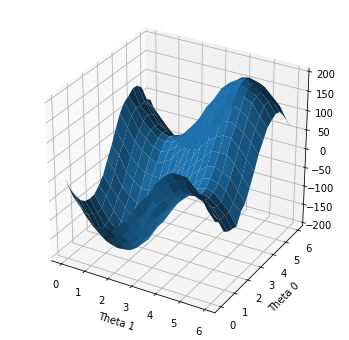

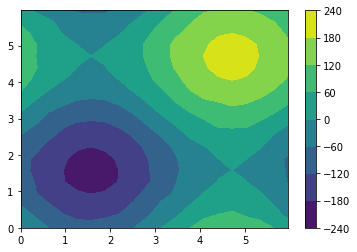

In [100]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
h = 100.0 #ratio of h/J

brute_force_2theta(m.pi/10, m.pi/10, np.array([0.0, 0.0]), np.array([2*m.pi, 2*m.pi]), h )



For large h, we might expect this to get skewed. Even if <x> = 0.01, for example, a large h could scale it a lot